# Satellite Image Captioning

Satellite images are trained on deep convolutional neural networks (CNNs) to learn image features and used multiple classification frameworks including gate recurrent unit label captioning and sparse_cross_entropy to predict multiclass, multi-label images. By fine tuning an architecture consisting of encoder of pre-trained VGG-19 parameters trained on ImageNet data together with the LSTM decoder

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import os

%matplotlib inline

from keras.models import Model,Sequential
from keras.layers import Input,Dense,GRU,LSTM,Embedding,Dropout,Flatten
from keras.layers.convolutional import Convolution2D,MaxPooling2D,ZeroPadding2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,ModelCheckpoint, TensorBoard  
from keras.preprocessing.text import Tokenizer
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences



Using TensorFlow backend.


In [2]:
data = pd.read_csv('train_v2.csv')
data[:5]

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
y_train = data['tags']
y_train.shape

(40479,)

In [4]:
mark_start = 'ssss '
mark_end = ' eeee'
def mark_captions(captions_list):
    captions_marked = [mark_start + caption + mark_end
                        for caption in captions_list]
                        
    
    return captions_marked

captions_train = mark_captions(y_train)
captions_train[0]

'ssss haze primary eeee'

In [5]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, padding,
                 reverse=False, num_words=None):
        """
        :param texts: List of strings. This is the data-set.
        :param padding: Either 'post' or 'pre' padding.
        :param reverse: Boolean whether to reverse token-lists.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

        # Convert all texts to lists of integer-tokens.
        # Note that the sequences may have different lengths.
        self.tokens = self.texts_to_sequences(texts)

        if reverse:
            # Reverse the token-sequences.
            self.tokens = [list(reversed(x)) for x in self.tokens]
        
            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        # The number of integer-tokens in each sequence.
        self.num_tokens = [len(x) for x in self.tokens]

        # Max number of tokens to use in all sequences.
        # We will pad / truncate all sequences to this length.
        # This is a compromise so we save a lot of memory and
        # only have to truncate maybe 5% of all the sequences.
        self.max_tokens = np.mean(self.num_tokens) \
                          + 2 * np.std(self.num_tokens)
        self.max_tokens = int(self.max_tokens)
        # Pad / truncate all token-sequences to the given length.
        # This creates a 2-dim numpy matrix that is easier to use.
        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                           padding=padding,
                                           truncating=truncating)

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def text_to_tokens(self, text, reverse=False, padding=False):
        """
        Convert a single text-string to tokens with optional
        reversal and padding.
        """

        # Convert to tokens. Note that we assume there is only
        # a single text-string so we wrap it in a list.
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)

        if reverse:
            # Reverse the tokens.
            tokens = np.flip(tokens, axis=1)

            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        if padding:
            # Pad and truncate sequences to the given length.
            tokens = pad_sequences(tokens,
                                   maxlen=self.max_tokens,
                                   padding='pre',
                                   truncating=truncating)

        return tokens

In [6]:
captions = TokenizerWrap(texts = captions_train,
                          padding = 'post',
                          reverse = False,
                          num_words = 10000)
caps = captions.tokens_padded
caps.shape

(40479, 7)

In [7]:
caps[2]

array([1, 4, 3, 2, 0, 0, 0], dtype=int32)

In [8]:
import scipy.io
import scipy.misc
from PIL import Image
import sys
import matplotlib.image as mpimg

agriculture clear habitation primary road
[ 1  5  4 11  3  7  2]
ssss agriculture clear habitation primary road eeee


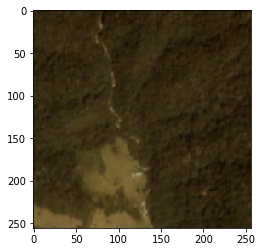

In [9]:
img=mpimg.imread('train/train_4.jpg')
print(y_train[4])
plt.imshow(img)
print(caps[4])
print(captions.tokens_to_string(caps[4]))

In [10]:
x = []
for i in range(2500):
    s = str(i) 
    if ('train_'+s+'.jpg') in os.listdir('train'):
        path = os.path.join('train','train_'+s+'.jpg')    
        image = Image.open(path).convert('RGB')
        image = image.resize((224,224))
        img_arr = np.asarray(image,dtype = 'float32')
        x.append(img_arr)
x = np.array(x)
x.shape

(2500, 224, 224, 3)

In [11]:
yin = caps[:2500]
yout = []
for each in yin:
    yout.append(each[1:7])
print(yin.shape)
#yout = np.array(yout)
#print(yout.shape)

(2500, 7)


In [12]:
z = np.array(0)
y_out = []
for i in yout:
    tmp = np.append(i,np.array(0))
    y_out.append(tmp)


In [13]:
y_out = np.array(y_out)
y_out.shape

(2500, 7)

In [14]:
from keras.optimizers import SGD

def VGG_19(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model



In [15]:
image_model = VGG_19(weights_path ='vgg19_weights_tf_dim_ordering_tf_kernels.h5')
image_model.summary()

/home/phantom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/home/phantom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/home/phantom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if sys.path[0] == '':
/home/phantom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  
/home/phantom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/home/phantom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: Use

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
__________

In [16]:
transfer_layer = image_model.get_layer('dense_2')

In [19]:
inputs = image_model.input
outputs = transfer_layer.output

image_model_transfer = Model(inputs = inputs,outputs = outputs)
image_model_transfer.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1_input (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
__________

In [21]:
image_model_transfer.save_weights('image_model.h5')

In [22]:
transfer_values = [image_model_transfer.predict(x)]

In [23]:
transfer_values = np.array(transfer_values)
trns = []
for each in transfer_values:
    for i in each:
        trns.append(i)
trns = np.array(trns)
print(trns.shape)
#print(transfer_values.shape)

(2500, 4096)


In [24]:
trns[999].shape

(4096,)

In [25]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
print(transfer_values_size)

4096


In [26]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')
print(transfer_values_input)

Tensor("transfer_values_input:0", shape=(?, 4096), dtype=float32)


In [27]:
decoder_transfer_map = Dense(512,
                             activation='tanh',
                             name='decoder_transfer_map')
decoder_input = Input(shape=(None,),name = 'decoder_input')
decoder_embedding = Embedding(input_dim=10000,
                              output_dim = 128,
                              name = 'decoder_embedding')
decoder_gru1 =  GRU(512,
                    name = 'decoder_gru1',
                    return_sequences = True)
decoder_gru2 = GRU(512,
                   name = 'decoder_gru2',
                   return_sequences = True)
decoder_gru3 = GRU(512,
                   name = 'decoder_gru3',
                   return_sequences = True)
decoder_dense = Dense(1000,
                      activation = 'linear',
                      name = 'decoder_output')

In [28]:
def connect_decoder(transfer_values):
    initial_state = decoder_transfer_map(transfer_values)
    net = decoder_input
    net = decoder_embedding(net)
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    net = decoder_dense(net)
    return net

In [29]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

In [30]:
decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [31]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
transfer_values_input (InputLay (None, 4096)         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          2097664     transfer_values_input[0][0]      
__________________________________________________________________________________________________
decoder_gr

In [32]:
l = decoder_model.get_layer('decoder_transfer_map')
sz = K.int_shape(l.input)
print("encoder out transfered decoder input size is - ",sz)
l = decoder_model.get_layer('decoder_input')
sz = K.int_shape(l.input)
print("decoder input caption size is - ",sz)

encoder out transfered decoder input size is -  (None, 4096)
decoder input caption size is -  (None, None)


In [33]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.losses.sparse_softmax_cross_entropy(labels=y_true,
                                              logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean
optimizer = RMSprop(lr=1e-3)
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      #metrics=['acc'],
                      target_tensors=[decoder_target])

In [34]:
x_data = {'decoder_input': yin,
          'transfer_values_input': trns}
y_data = {'decoder_output': y_out}

In [35]:
decoder_model.fit(x = x_data,y = y_data,
                            batch_size=50,
                            epochs=25)


Epoch 1/25
2500/2500 [==============================] - 4s 2ms/step - loss: 1.5274
Epoch 2/25
2500/2500 [==============================] - 2s 733us/step - loss: 0.6701
Epoch 3/25
2500/2500 [==============================] - 2s 761us/step - loss: 0.4359
Epoch 4/25
2500/2500 [==============================] - 2s 741us/step - loss: 0.3365
Epoch 5/25
2500/2500 [==============================] - 2s 726us/step - loss: 0.2903
Epoch 6/25
2500/2500 [==============================] - 2s 720us/step - loss: 0.2495
Epoch 7/25
2500/2500 [==============================] - 2s 734us/step - loss: 0.2324
Epoch 8/25
2500/2500 [==============================] - 2s 744us/step - loss: 0.2107
Epoch 9/25
2500/2500 [==============================] - 2s 734us/step - loss: 0.1949
Epoch 10/25
2500/2500 [==============================] - 2s 737us/step - loss: 0.1828
Epoch 11/25
2500/2500 [==============================] - 2s 736us/step - loss: 0.1721
Epoch 12/25
2500/2500 [==============================] - 2s 734us

In [36]:
decoder_model.save_weights('decoder_model.h5')

In [37]:
def generate_caption(image_path, max_tokens=7):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    tst_img = []
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224,224))
    img_arr = np.asarray(image,dtype = 'float32')
    tst_img.append(img_arr)
    tst_img = np.array(tst_img)
    #image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    #image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(tst_img)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = 1

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != 2 and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = captions.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

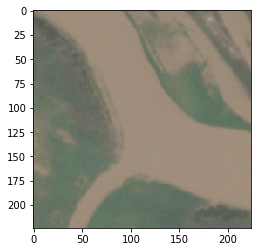

Predicted caption:
 clear primary water eeee



In [40]:
generate_caption("1.jpg")


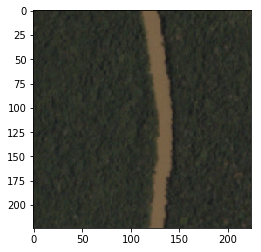

Predicted caption:
 clear primary water eeee



In [41]:
generate_caption("2.jpg")


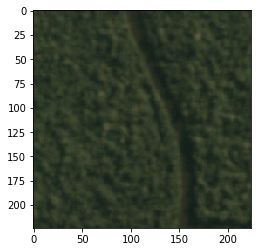

Predicted caption:
 clear primary eeee



In [42]:
generate_caption("3.jpg")


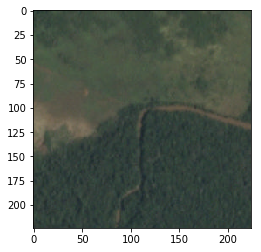

Predicted caption:
 agriculture clear cultivation primary road eeee



In [43]:
generate_caption("4.jpg")


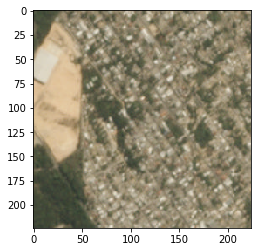

Predicted caption:
 agriculture clear habitation primary road eeee



In [44]:
generate_caption("5.jpg")
